In [1]:
%load_ext autoreload
%autoreload 2

from Cartesian_MACE.models.model import CartesianMACE
from Cartesian_MACE.utils.cartesian_contractions import create_zero_feature_tensors
from typing import List
from torch.nn import Embedding

import torch


In [3]:
# first do this for a single layer
# easier this way!
torch.manual_seed(0)
dim = 2  # start off in 2D to keep things simple
n_neighbours = 5
n_channels = 3
feature_rank_max = 2
basis_rank_max = 2
self_tp_rank_max = 2  # max rank of self TP
nu_max = 4
c_out_max = 2

[Data(edge_index=[2, 5], y=[1], pos=[6, 2], atoms=[6, 1]), Data(edge_index=[2, 5], y=[1], pos=[6, 2], atoms=[6, 1]), Data(edge_index=[2, 5], y=[1], pos=[6, 2], atoms=[6, 1])]


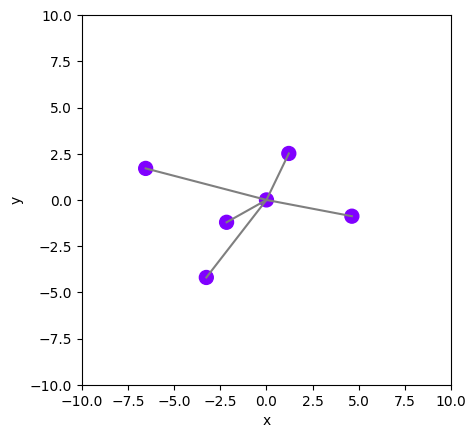

In [4]:
# create dataset that is the same as my current data just in the pytroch geometric way!
from torch_geometric.data import Data, Batch
from torch_geometric.utils import is_undirected, to_undirected
from torch_geometric.loader import DataLoader
from src.utils.plot_utils import plot_2d

def create_dataset(size: int, n_neighbours: int) -> List[Data]:
    dataset = []

    for _ in range(size):
        atoms= torch.zeros(n_neighbours+1,1).long()
        edge_index = torch.LongTensor([[0] * n_neighbours, [i for i in range(1,n_neighbours + 1)]])
        pos_central = torch.zeros(1,2)
        pos_neighbours =  3 * torch.randn(n_neighbours,dim)
        pos = torch.cat((pos_central, pos_neighbours))
        y = torch.Tensor([0]) # label

        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)

        dataset.append(data)

    return dataset


dataset = create_dataset(size=3,n_neighbours=5)

print(dataset)
# need to add this back in once I find out how
# data.edge_index = to_undirected(data.edge_index)
# print(data)

plot_2d(dataset[0])

In [5]:
# figure out how the embedding works
# emb_in Embedding(in_dim, emb_dim)

h, h_central = create_zero_feature_tensors(feature_rank_max=feature_rank_max,n_neighbours=n_neighbours,n_channels=n_channels,dim=dim)

# simulate late on layer include the others
h[0] += torch.randn(n_neighbours, n_channels, 1)
# h[1] += torch.randn(n_neighbours, n_channels, 2)
# h[2] += torch.randn(n_neighbours, n_channels, 2,2)
h_central[0] += torch.randn(n_channels, 1)

In [6]:
# instantiate the model
cartesian_mace = CartesianMACE(
    n_channels=n_channels,
    n_neighbours=n_neighbours,
    self_tp_rank_max=self_tp_rank_max,
    basis_rank_max=basis_rank_max,
    dim=dim,
    n_layers=5,
    nu_max=nu_max,
    feature_rank_max=feature_rank_max,
)

# do a forward pass
cartesian_mace(data=dataset[0])

tensor([[-26.6607],
        [-67.0594],
        [-99.8695]], grad_fn=<AsStridedBackward0>)

In [7]:
# shapes are as expected
[g.shape for g in h], [g.shape for g in h_central]

([torch.Size([5, 3, 1]), torch.Size([5, 3, 2]), torch.Size([5, 3, 2, 2])],
 [torch.Size([3, 1]), torch.Size([3, 2]), torch.Size([3, 2, 2])])

In [8]:
cartesian_mace = CartesianMACE(
    n_channels=n_channels,
    n_neighbours=n_neighbours,
    self_tp_rank_max=self_tp_rank_max,
    basis_rank_max=basis_rank_max,
    dim=dim,
    n_layers=1,
    nu_max=nu_max,
    feature_rank_max=feature_rank_max,
)

# this becomes more important later
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cartesian_mace(data=dataset[0])

tensor([[ 4.1407],
        [ 4.1030],
        [-2.8690]], grad_fn=<AsStridedBackward0>)

In [9]:
cartesian_mace.eval()

CartesianMACE(
  (emb_in): Embedding(1, 3)
  (create_atomic_bases): ModuleList(
    (0): AtomicBasis(
      (contractions): ModuleDict(
        (00:0): CartesianContraction()
        (01:1): CartesianContraction()
        (02:0): CartesianContraction()
        (02:2): CartesianContraction()
      )
    )
  )
  (weighted_sums): ModuleList(
    (0): WeightedSum(
      (contractions): ModuleDict(
        (0:0): CartesianContraction()
        (1:1): CartesianContraction()
        (2:0): CartesianContraction()
        (2:2): CartesianContraction()
        (00:0): CartesianContraction()
        (01:1): CartesianContraction()
        (02:0): CartesianContraction()
        (02:2): CartesianContraction()
        (11:0): CartesianContraction()
        (11:2): CartesianContraction()
        (12:1): CartesianContraction()
        (22:0): CartesianContraction()
        (22:2): CartesianContraction()
        (000:0): CartesianContraction()
        (001:1): CartesianContraction()
        (002:0): Car